# Discount Impact
- Compare `Discount` Sales and `Non-Discount` Sales by Top selling Products and how it trends over Year

### Loading data

In [2]:
# Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sqlalchemy import create_engine

# Define the connection details
server = 'DESKTOP-D57LVN9\SQLEXPRESS'
database = 'ContosoRetail'
username = 'sa'
password = '281202'

# Create the connection string
connection_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server'

# Create the engine
engine = create_engine(connection_string)

# Write SQL query
query = "select * from ContosoRetail_df"

# Load data into a pandas DataFrame
df_origin = pd.read_sql(query, engine, index_col='SalesKey')

# No need to explicitly close the engine, but it’s good practice to dispose of it when done
engine.dispose()

<>:8: SyntaxWarning: invalid escape sequence '\S'
<>:8: SyntaxWarning: invalid escape sequence '\S'
C:\Users\duyvn\AppData\Local\Temp\ipykernel_1884\3571089307.py:8: SyntaxWarning: invalid escape sequence '\S'
  server = 'DESKTOP-D57LVN9\SQLEXPRESS'


### Calculating Discounts Sales and Non-Discounts Sales

In [3]:
# Discount and Non-Discount
df_discounts = df_origin[df_origin['DiscountAmount'] > 0][['ProductName','SalesAmount']]
df_non_discounts = df_origin[df_origin['DiscountAmount'] == 0][['ProductName','SalesAmount']]

# Calculating total sales for Discount and Non-Discount
df_discounts = df_discounts.groupby('ProductName')['SalesAmount'].sum().to_frame(name='Sales_Discounts')
df_non_discounts = df_non_discounts.groupby('ProductName')['SalesAmount'].sum().to_frame(name='Sales_Non_Discounts')

In [4]:
df_discounts

,Sales_Discounts
ProductName,
A. Datum Advanced Digital Camera M300 Azure,1.661709e+06
A. Datum Advanced Digital Camera M300 Black,2.279877e+06
A. Datum Advanced Digital Camera M300 Green,2.189746e+06
A. Datum Advanced Digital Camera M300 Grey,2.156216e+06
A. Datum Advanced Digital Camera M300 Orange,2.313728e+06
...,...
WWI Wireless Transmitter and Bluetooth Headphones X250 Black,8.485961e+05
WWI Wireless Transmitter and Bluetooth Headphones X250 Blue,1.002597e+06
WWI Wireless Transmitter and Bluetooth Headphones X250 Red,9.142809e+05


In [5]:
df_non_discounts

,Sales_Non_Discounts
ProductName,
A. Datum Advanced Digital Camera M300 Azure,1861437.50
A. Datum Advanced Digital Camera M300 Black,1823360.50
A. Datum Advanced Digital Camera M300 Green,1950975.00
A. Datum Advanced Digital Camera M300 Grey,1662758.50
A. Datum Advanced Digital Camera M300 Orange,1907054.50
...,...
WWI Wireless Transmitter and Bluetooth Headphones X250 Black,761469.54
WWI Wireless Transmitter and Bluetooth Headphones X250 Blue,674223.03
WWI Wireless Transmitter and Bluetooth Headphones X250 Red,731470.74


### Merging 2 DataFrames for comparison

In [6]:
# Merging 2 DataFrames
df_discounts_merge = df_discounts.merge(df_non_discounts, on='ProductName').reset_index().sort_values(by=(['Sales_Discounts','Sales_Non_Discounts']), ascending=False).tail(10)
df_discounts_merge

,ProductName,Sales_Discounts,Sales_Non_Discounts
551,Contoso Digital Camera Accessory kit M200 Blue,38850.6450,38359.50
897,Contoso Smart Battery M901 Blue,33831.0450,20884.00
2184,SV USB Sync Charge Cable E700 Black,15594.4161,11400.71
2185,SV USB Sync Charge Cable E700 Blue,15269.9068,11683.29
2187,SV USB Sync Charge Cable E700 White,14854.2157,11086.29
2186,SV USB Sync Charge Cable E700 Silver,13993.7198,11012.66
2183,SV USB Data Cable E600 Silver,9993.1925,6497.05
2180,SV USB Data Cable E600 Black,9078.5895,6546.45
2181,SV USB Data Cable E600 Grey,8959.9345,7129.75
2182,SV USB Data Cable E600 Pink,8278.0245,6704.15


### Plotting to see which Total Sales is higher

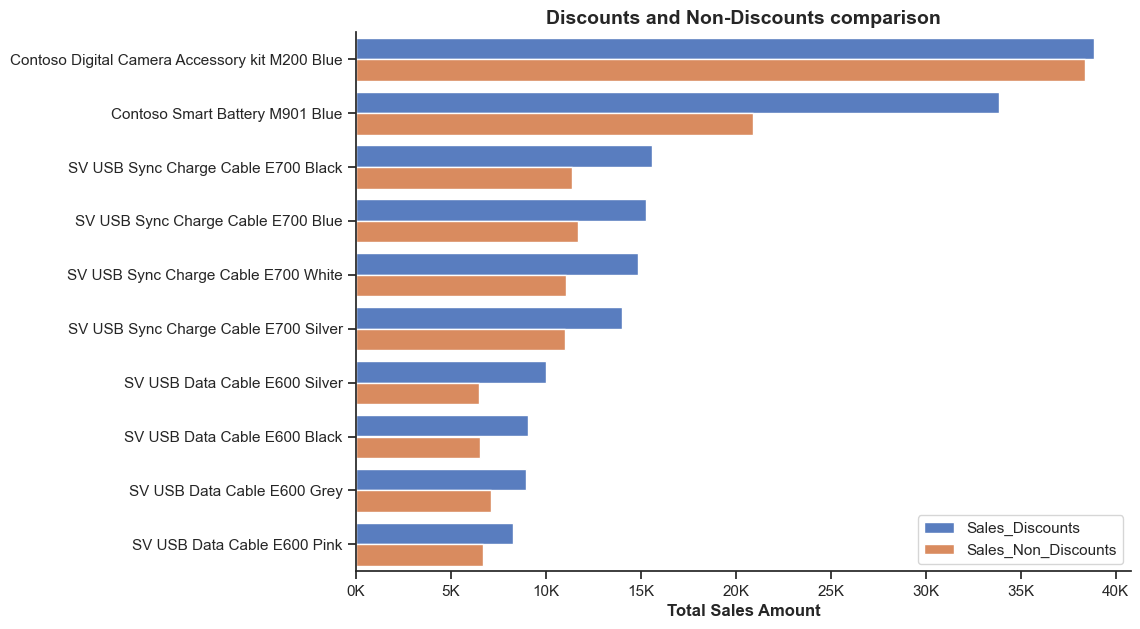

In [7]:
# Melting DataFrame
df_discounts_merge_melt = df_discounts_merge.melt(id_vars='ProductName', var_name='Metrics', value_name='Amount')

# Plotting
plt.figure(figsize=(10,7))
sns.set_theme(style='ticks')
barplot = sns.barplot(
    data=df_discounts_merge_melt,
    x='Amount',
    y='ProductName',
    hue='Metrics',
    palette='muted'
)
sns.despine()

# Formatting plot
plt.title('Discounts and Non-Discounts comparison', fontweight='bold', fontsize=14)
plt.xlabel('Total Sales Amount', fontweight='bold')
plt.ylabel('')
plt.legend(loc='lower right')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000)}K'))

### Discount and Non-Discount Trend

In [94]:
# Calculating Net Impact of Discounts
df_date_discounts = df_origin[df_origin['DiscountAmount'] > 0][['DateKey','SalesAmount']].rename(columns={"SalesAmount": "Sales_Discount"})
df_date_non_discounts = df_origin[df_origin['DiscountAmount'] == 0][['DateKey','SalesAmount']].rename(columns={"SalesAmount": "Sales_Non_Discount"})

# Create year and month columns
df_date_discounts['Month'] = df_date_discounts['DateKey'].dt.month
df_date_discounts['Year'] = df_date_discounts['DateKey'].dt.year

df_date_non_discounts['Month'] = df_date_non_discounts['DateKey'].dt.month
df_date_non_discounts['Year'] = df_date_non_discounts['DateKey'].dt.year

# Pivot table
df_discounts_pivot = df_date_discounts.pivot_table(index='Month', columns='Year', values='Sales_Discount', aggfunc='sum')
df_non_discounts_pivot = df_date_non_discounts.pivot_table(index='Month', columns='Year', values='Sales_Non_Discount', aggfunc='sum')

# Convert month num to month name
df_discounts_pivot = df_discounts_pivot.reset_index()
df_discounts_pivot['Month'] = df_discounts_pivot['Month'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%b'))
df_discounts_pivot = df_discounts_pivot.set_index('Month')

df_non_discounts_pivot = df_non_discounts_pivot.reset_index()
df_non_discounts_pivot['Month'] = df_non_discounts_pivot['Month'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%b'))
df_non_discounts_pivot = df_non_discounts_pivot.set_index('Month')

In [95]:
df_discounts_pivot

Year,2022,2023,2024
Month,,,
Jan,2.275839e+08,2.342752e+08,2.255944e+08
Feb,2.540907e+08,2.342266e+08,2.317856e+08
Mar,2.514440e+08,2.427031e+08,2.267475e+08
Apr,3.906515e+07,6.703345e+07,6.084110e+07
May,5.741646e+07,7.246488e+07,7.490757e+07
Jun,5.475199e+07,6.879543e+07,7.303941e+07
Jul,1.948108e+08,1.888152e+08,1.462103e+08
Aug,2.728195e+08,2.396277e+08,1.957785e+08
Sep,2.679304e+08,2.338876e+08,1.869420e+08


In [96]:
df_non_discounts_pivot

Year,2022,2023,2024
Month,,,
Jan,4.225140e+07,4.518565e+07,4.417594e+07
Feb,4.412524e+07,4.474934e+07,4.409378e+07
Mar,4.904297e+07,4.735747e+07,4.402242e+07
Apr,3.610952e+08,2.891057e+08,2.483167e+08
May,3.660127e+08,2.786321e+08,2.666527e+08
Jun,3.550456e+08,2.693374e+08,2.582606e+08
Jul,1.948066e+08,1.972090e+08,1.871641e+08
Aug,1.156103e+08,1.203104e+08,1.292518e+08
Sep,1.112142e+08,1.195343e+08,1.268383e+08


C:\Users\duyvn\AppData\Local\Temp\ipykernel_1884\3098395328.py:8: UserWarning: 
The markers list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(
C:\Users\duyvn\AppData\Local\Temp\ipykernel_1884\3098395328.py:16: UserWarning: 
The markers list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


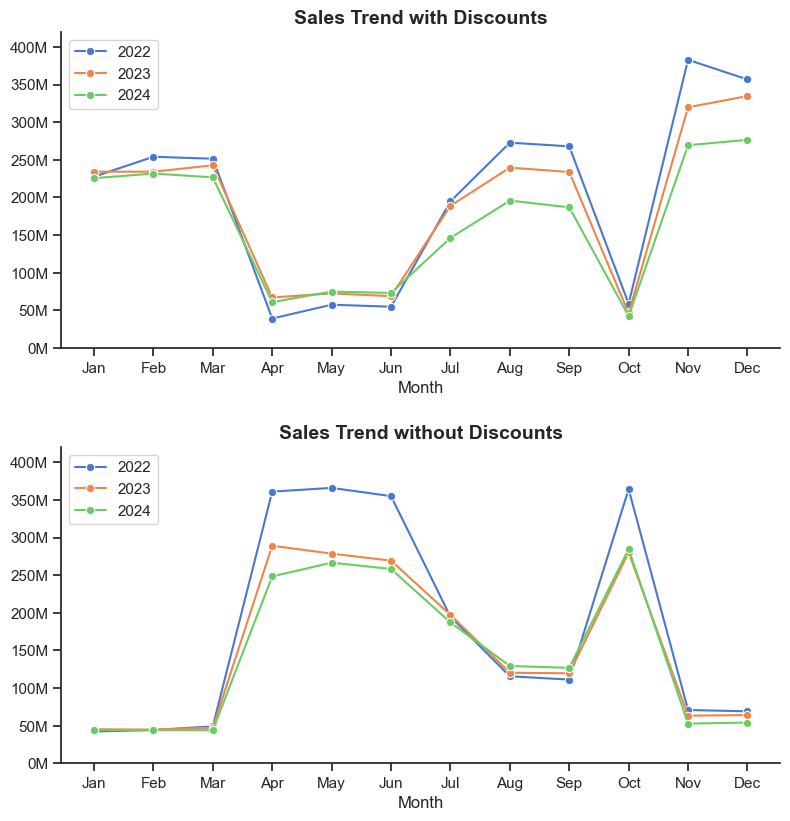

In [121]:
# Subplots
fig, ax = plt.subplots(2,1, figsize=(8,8))
fig.tight_layout(h_pad=4)

# Plotting
sns.set_theme(style='ticks')

sns.lineplot(
    data=df_discounts_pivot,
    ax=ax[0],
    dashes=False,
    markers='o',
    palette='muted'
)

sns.lineplot(
    data=df_non_discounts_pivot,
    ax=ax[1],
    dashes=False,
    markers='o',
    palette='muted'
)

sns.despine()

# Formatting plot
ax[0].set_title('Sales Trend with Discounts', fontsize=14, fontweight='bold')
ax[0].set_ylim(0,420000000)
ax[0].legend(title=False)
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000000)}M'))

ax[1].set_title('Sales Trend without Discounts', fontsize=14, fontweight='bold')
ax[1].set_ylim(0,420000000)
ax[1].legend(title=False, loc='upper left')
ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000000)}M'))

plt.show()